In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import glob
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from timm.models.maxxvit import window_partition,window_reverse
from unet import UNETModel 

/home/ubuntu/DuyPham/.venv/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from dysta_block import *

# Define Dataset Class and DataLoader

In [3]:
def apply_gamma_correction(image, gamma=1.0):
    image_normalized = image / 255.0
    gamma_corrected = np.power(image_normalized, gamma)
    gamma_corrected = np.uint8(gamma_corrected * 255)

    return gamma_corrected

In [4]:
def preprocessing_img(path):
    img=cv2.imread(path,0)
    clahe = cv2.createCLAHE(clipLimit=11, tileGridSize=(12, 12))
    clahe_img = clahe.apply(img)
    out = apply_gamma_correction(clahe_img,2)

    return out

In [5]:
def sobel_transforms(image):
    blur_img=cv2.GaussianBlur(image,(3,3),1)
    sb_x =cv2.Sobel(blur_img,-1,1,0)
    sb_y =cv2.Sobel(blur_img,-1,0,1)
    sb = (sb_x+sb_y)/2
    return sb

In [6]:
class CustomDataset(Dataset):
    def __init__(self,img_paths,mask_paths,img_transforms=None):
        super().__init__()
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.img_transforms = img_transforms
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        mask_path = self.mask_paths[index]
        img  = cv2.cvtColor(cv2.imread(img_path,0),cv2.COLOR_GRAY2RGB)
        sobel = sobel_transforms(img)
        mask = np.array(Image.open(mask_path),dtype=int)
        if self.img_transforms is not None:
            transform =  self.img_transforms(image = img,mask=mask)
            t_image  = transform['image']
            t_mask =  transform['mask']
            t_sobel = self.img_transforms(image = sobel)['image']
        else:
            raise Exception('Transforms is compulsory')
        
        return {
            'image':t_image,
            'sobel':t_sobel,
            'mask':t_mask,
        }

In [7]:
image_paths = sorted(glob.glob('/home/ubuntu/DuyPham/data/*jpg'))
mask_paths = sorted(glob.glob('/home/ubuntu/DuyPham/data/*1stHO.png'))

**Split to train test**

In [8]:
train_image_paths = image_paths[:20]
test_image_paths =  image_paths[20:]

train_mask_paths = mask_paths[:20]
test_mask_paths =  mask_paths[20:]

**Define train_set and train_image_transforms**

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_image_transforms = A.Compose(
    [
        A.Resize(960, 960, interpolation=cv2.INTER_AREA),  
        A.Normalize(mean=(0.1874, 0.1874, 0.1874), std=(0.2009, 0.2009, 0.2009)),
        ToTensorV2(),  
    ],
    # additional_targets={'sobel': 'image', 'image': 'image', 'mask': 'mask'}
)

In [44]:
def decode(img):
    clone_img = img.clone().squeeze().detach().cpu()
    if len(clone_img.shape) > 2:
        clone_img=clone_img.permute(1,2,0).numpy()
    else:
        clone_img=clone_img.numpy()
    clone_img=clone_img*0.2009+0.1874
    return (clone_img*255).astype(np.uint8)


In [11]:
train_set = CustomDataset(train_image_paths,train_mask_paths,train_image_transforms)
test_set = CustomDataset(test_image_paths,test_mask_paths,train_image_transforms)

In [12]:
batch_size = 1
train_loader = DataLoader(train_set,batch_size,shuffle=True,num_workers=8,generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_set,batch_size,shuffle=False)

# Define Model

## Define all Blocks

In [ ]:
class Depwise(nn.Module):
    def __init__(self,in_channels,out_channels,dialtion=1,bias=True):
        super().__init__()
        self.out =  nn.Sequential(
            nn.Conv2d(in_channels,in_channels,3,groups=in_channels,bias=True,dilation=dialtion,padding='same'),
            nn.Conv2d(in_channels,out_channels,1,bias=bias)
        )
    def forward(self,x):
        
        return self.out(x)

In [14]:
class Residual_Depwise_Block(nn.Module):
    def __init__(self,in_channels,out_channels,num_conv=2):
        super().__init__()
        self.change_channels = nn.Conv2d(in_channels,out_channels,3,padding='same')
     
        model_list=[
           nn.Sequential(
               Depwise(in_channels,out_channels),
               nn.ReLU(),
               nn.BatchNorm2d(out_channels))
        ]
        for _ in range(1,num_conv):
            model_list.extend([nn.Sequential(Depwise(out_channels,out_channels),nn.ReLU(),
               nn.BatchNorm2d(out_channels))])
        merge_lst = [nn.Conv2d(2*out_channels,out_channels,3,padding='same'),] 
        # if last == False:
        merge_lst.append(nn.ReLU())
        merge_lst.append(nn.BatchNorm2d(out_channels))
        self.merge = nn.Sequential(*merge_lst
        )
        self.out = nn.Sequential(
            *model_list
        )
    def forward(self,x):
        x0=self.change_channels(x)
        x1=self.out(x)
        return  self.merge(torch.cat((x0,x1),1))

In [15]:
# class SAP(nn.Module):
#     def __init__(self,in_channels):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels,in_channels,2,2),
#             nn.ReLU(),nn.BatchNorm2d(in_channels)
#         )
#         self.ln =  nn.Linear(in_channels,3*in_channels)
#         self.up_sample =  nn.Sequential(nn.ConvTranspose2d(in_channels,in_channels,2,2),nn.ReLU(),nn.BatchNorm2d(in_channels))
#         self.norm =  nn.LayerNorm(in_channels)
#         self.out = nn.Sequential(
#             nn.Linear(4*in_channels,in_channels),
#             nn.ReLU(),
#             nn.Linear(in_channels,in_channels)
#         )
#         self.pool = nn.MaxPool2d(2)
#         self.dw = nn.Sequential(Depwise(2*in_channels,in_channels),nn.BatchNorm2d(in_channels))
#     def forward(self,x):
#         pool_x = self.pool(x)
#         down_x=self.conv(x).permute(0,2,3,1).contiguous()
#         b,h,w,c = down_x.shape
#         partition =  window_partition(down_x,[2,2]).flatten(1,2)
#         q,k,v = self.ln(partition).chunk(3,-1)
#         corr = F.softmax(F.normalize((q@k.transpose(1,2)),dim=-1),-1)
#         out = window_reverse(self.norm(corr@v),[2,2],[h,w]).permute(0,3,1,2).contiguous()
#         out = self.up_sample(out)
#         out=self.out(out.unfold(-2,2,2).unfold(-2,2,2).flatten(-2).permute(0,2,3,4,1).contiguous().flatten(-2))
#         return self.dw(torch.cat((pool_x,out.permute(0,3,1,2).contiguous()),1))

In [16]:
# class Dynamic_Conv(nn.Module):
#     def __init__(self,in_channels,out_channels,kernel_size,dilation=1,K=2):
#         super().__init__()
#         self.se =  nn.Sequential(
#             nn.AdaptiveMaxPool2d(1),
#             nn.Conv2d(in_channels,in_channels,1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels,K,1),
#         ) #B,k,1,1
#         self.w = nn.Parameter(torch.rand(K,out_channels,in_channels,kernel_size,kernel_size))
#         self.bias = nn.Parameter(torch.zeros(K,out_channels))
#         self.d=dilation
#     def forward(self,x):
#         B,_,h,w=x.shape
#         se = F.softmax(F.normalize(self.se(x),dim=1),1).squeeze() #B,k
#         K,out_channels,in_channels,kernel_size,kernel_size = self.w.shape
#         attn_w=se@(self.w.flatten(1,-1)) #B,out_channels*in_channels*kernel_size*kernel_size
#         attn_w=attn_w.view(-1,in_channels,kernel_size,kernel_size)#B*out_channels,C,kernel_size,kernel_size
#         attn_bias = se@self.bias #B,out_channels
#         x=x.flatten(0,1).unsqueeze(0) #1,B*C,h,w
#         return F.ReLU(F.conv2d(x,weight=attn_w,bias=attn_bias.view(-1),groups=B,padding='same',dilation=self.d).view(-1,out_channels,h,w))

In [17]:
# class MFE(nn.Module):
#     def __init__(self,in_channels,out_channels):
#         super().__init__()
#         self.conv_0 = nn.Sequential(
#             Depwise(in_channels,in_channels),
#             nn.BatchNorm2d(in_channels))
#         self.conv_1 = nn.Sequential(
#             Depwise(in_channels,in_channels),
#             nn.BatchNorm2d(in_channels),
#             nn.Sigmoid())
#         self.conv_2 = nn.Sequential(
#             Depwise(in_channels,in_channels),
#             nn.BatchNorm2d(in_channels))
#         self.conv_3 = nn.Sequential(
#             Depwise(in_channels,in_channels),
#             nn.BatchNorm2d(in_channels),
#             nn.Sigmoid())
#         self.conv_4= nn.Sequential(
#             Depwise(in_channels,in_channels),
#             nn.BatchNorm2d(in_channels),
#             nn.ReLU(),
#             )
#         self.conv_5 =nn.Sequential(
#             Depwise(in_channels,in_channels),
#             nn.BatchNorm2d(in_channels),
#             nn.ReLU(),
#         )
#         self.conv_6 =nn.Sequential(
#             Depwise(2*in_channels,in_channels),
#             nn.BatchNorm2d(in_channels),
#             nn.ReLU(),)
#         self.change_channels = nn.Sequential(Depwise(3*in_channels,out_channels,bias=True),nn.BatchNorm2d(out_channels),nn.ReLU())
                                             
#     def forward(self,x0,x1):
#         conv_0 = self.conv_0(x0)
#         conv_1_s = self.conv_1(x0)
#         new_x1 = x1*conv_1_s
#         new_x1 = self.conv_4(new_x1)
#         conv_2 = self.conv_2(x1)
#         conv_3_s = self.conv_3(x1)
#         new_x0 = x0*conv_3_s
#         new_x0 = self.conv_5(new_x0)
#         new_x0=new_x0+conv_2
#         new_x1=new_x1+conv_0
#         return self.change_channels(torch.cat((self.conv_6(torch.cat((new_x0,new_x1),1)),x0,x1),1))

In [18]:
class MSB(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.change_dim = nn.Conv2d(in_channels,out_channels,3,padding='same',bias=True)
        self.branch_0 = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,3,padding='same'),
            nn.BatchNorm2d(out_channels)
        )
        self.ln_1 =nn.Linear(in_channels,out_channels,bias=True)
        self.ln_2 =nn.Linear(in_channels,out_channels,bias=True)
        self.ln_3 =nn.Linear(in_channels,out_channels,bias=True)

        self.branch_1 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,3,padding='same'),
            nn.BatchNorm2d(out_channels),
        )
        self.branch_2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,5,padding='same'),
            nn.BatchNorm2d(out_channels)
        )
        self.branch_3 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,7,padding='same'),
            nn.BatchNorm2d(out_channels)
        )
        self.merge = nn.Sequential(
            nn.Linear(4*out_channels,out_channels),
            nn.ReLU()
        )
    def forward(self,x):
        b_0 = self.branch_0(x)+self.change_dim(x)
        x_1 = self.ln_1(x.permute(0,2,3,1).contiguous()).permute(0,3,1,2).contiguous()
        x_2 = self.ln_2(x.permute(0,2,3,1).contiguous()).permute(0,3,1,2).contiguous()
        x_3 = self.ln_3(x.permute(0,2,3,1).contiguous()).permute(0,3,1,2).contiguous()

        b_1 = self.branch_1(x_1)
        b_2 =self.branch_2(b_1+x_2)
        b_3 =self.branch_3(b_2+x_3)
        main_b = torch.cat((b_0,b_1,b_2,b_3),1)
        return self.merge(main_b.permute(0,2,3,1).contiguous()).permute(0,3,1,2).contiguous()


In [19]:
class EEB(nn.Module):
    def __init__(self,out_channels,size):
        super().__init__()
        self.change_channels_edge = Depwise(3,out_channels)
        self.ln = nn.Sequential(
            nn.Linear(out_channels,2*out_channels),
            nn.ReLU(),
            nn.Linear(2*out_channels,out_channels),
            nn.Sigmoid())
        self.pool = nn.AdaptiveMaxPool2d(size)
        self.fc =  nn.Sequential(nn.Linear(out_channels,out_channels),nn.ReLU())
      
        self.merge = nn.Sequential(
            nn.Conv2d(2*out_channels,out_channels,3,bias=False,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels,out_channels,3,padding='same',bias=True,groups=out_channels),
            nn.Conv2d(out_channels,out_channels,1,bias=False),
            )
    def forward(self,edge):
        b,c,h,w = edge.shape
        edge =  self.change_channels_edge(edge)
        ln_edge = self.ln(edge.permute(0,2,3,1).contiguous())
        edge = edge*(ln_edge.permute(0,3,1,2).contiguous())
        edge = self.pool(edge)
        fc_edge = self.fc(edge.permute(0,2,3,1).contiguous())

        out = self.merge(torch.cat((edge,fc_edge.permute(0,3,1,2).contiguous()),1))
        return out


In [20]:
class Global_Attention_Block(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.ln = nn.Sequential(
            # nn.LayerNorm(in_channels),
            nn.Linear(in_channels,3*in_channels))
        self.out= nn.Sequential(nn.Linear(in_channels,in_channels),nn.ReLU())
        self.ffw = nn.Sequential(
            # nn.LayerNorm(in_channels),
            nn.Linear(in_channels,in_channels//4,bias=True),
            nn.ReLU(),
            nn.Linear(in_channels//4,in_channels,bias=True)
        )
    def forward(self,x):
        _,c,h,w = x.shape

        new_x  = x.permute(0,2,3,1).contiguous().flatten(1,2)
        new_x_1 = self.ln(new_x)
        q,k,v = new_x_1.chunk(3,-1)
        mm = F.softmax((q@k.transpose(1,2))/(c*h*w),-1)
        attn  = self.out(mm@v)
        return (self.ffw(attn)+ new_x).view(-1,h,w,c).permute(0,3,1,2).contiguous()

In [21]:
class Window_Attention_Block(nn.Module):
    def __init__(self,in_channels,window_size=4):
        super().__init__()
        self.window_size = window_size
        self.ln = nn.Sequential(
            nn.Linear(in_channels,3*in_channels))
        self.out =  nn.Sequential(nn.Linear(in_channels,in_channels),nn.ReLU())
        self.ffw = nn.Sequential(
            # nn.LayerNorm(in_channels),
            nn.Linear(in_channels,in_channels//4),
            nn.ReLU(),
            nn.Linear(in_channels//4,in_channels)
        )
    def forward(self,x):
        b,c,h,w = x.shape
        window_x = window_partition(x.permute(0,2,3,1),[self.window_size,self.window_size])
        window_x = window_x.view(b,-1,self.window_size,self.window_size,c).flatten(2,3)
        new_window_x = self.ln(window_x)
        q,k,v = new_window_x.chunk(3,-1)
        mm = F.softmax((q@k.transpose(-1,-2))/(c*self.window_size*self.window_size),-1)
        attn  = self.out(mm@v).flatten(1,2) #b,num_window,h*w,c
        attn=self.ffw(attn) 
        
        return window_reverse(attn,[self.window_size,self.window_size],[h,w]).permute(0,3,1,2).contiguous()+x

In [22]:
class Inception_Block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.branch_1= nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )
        self.branch_2= nn.Sequential(
            nn.Conv2d(in_channels,out_channels,(1,5),padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels,out_channels,(5,1),padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        self.branch_3= nn.Sequential(Depwise(in_channels,out_channels,2),nn.ReLU(),
            nn.BatchNorm2d(out_channels))
        self.branch_4= nn.Sequential(Depwise(in_channels,out_channels,3),nn.ReLU(),
            nn.BatchNorm2d(out_channels))
        self.merge = Depwise(2*out_channels,out_channels)

    def forward(self,x):
        b1=self.branch_1(x)
        b2=self.branch_2(x)
        b3=self.branch_3(x)
        b4=self.branch_4(x)
        return  self.merge(torch.cat(((b1+b2),(b3+b4)),1))

In [23]:
# class SE_Block(nn.Module):
#     def __init__(self,in_channels,out_channels):
#         super().__init__()
#         self.change_channels = nn.Conv2d(in_channels,out_channels,1,bias=True)
#         self.first_block=Residual_Depwise_Block(in_channels,in_channels)
#         self.global_pool = nn.AdaptiveMaxPool2d(1)
#         self.hidden = nn.Sequential(
#             nn.Linear(in_channels,in_channels//4),
#             nn.ReLU(),
#             nn.Linear(in_channels//4,in_channels),
#             nn.Sigmoid()
#         )
#     def forward(self,x):
#         first_x = self.first_block(x)
#         pool_x = self.global_pool(first_x).permute(0,2,3,1)
#         hidden = self.hidden(pool_x)
#         out = (first_x.permute(0,2,3,1)*hidden).permute(0,3,1,2)
#         out=out+x
#         return self.change_channels(out)

In [24]:
class EFB(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.ln_1 = nn.Linear(in_channels//2,in_channels//2,bias=True)
        self.ln_2 = nn.Linear(in_channels//2,3*in_channels//2,bias=True)
        self.out_1 = nn.Sequential(
            nn.Linear(in_channels//2,in_channels//2),
        )
        self.out_2 = nn.Sequential(
            nn.Linear(in_channels,in_channels//2),
        )
        self.out = nn.Sequential(
            nn.Linear(in_channels,in_channels),
            nn.ReLU(),
        )
    def forward(self,x):
        x1,x2 = torch.chunk(x,2,1)
        b,half_c,h,w = x1.shape

        new_domain_x2 = self.ln_2(x2.permute(0,2,3,1).contiguous()).permute(0,3,1,2).contiguous()
        new_domain_x1 = self.ln_1(x1.permute(0,2,3,1).contiguous()).permute(0,3,1,2).contiguous()

        new_domain_x1=new_domain_x1.flatten(2)
        new_domain_x2=new_domain_x2.flatten(2)

        q_x2,k_x2,v_x2 = new_domain_x2.chunk(3,1)

        attn_x2 = F.softmax((q_x2@(k_x2.transpose(1,2)))/(h*w*half_c),-1)@v_x2

        x2 = self.out_2(torch.cat((x2,attn_x2.view(b,half_c,h,w)),1).permute(0,2,3,1).contiguous())\
                                                                    .permute(0,3,1,2).contiguous().flatten(2)

        x1 = x1.flatten(2)
        
        corr = nn.Sigmoid()(F.softmax((new_domain_x1@(x2.transpose(1,2)))/(h*w*half_c),-1)@x2)
        x1 = x1*corr+x1

        x1 = self.out_1(x1.view(b,half_c,h,w).permute(0,2,3,1).contiguous()).permute(0,3,1,2).contiguous()
        x2 = x2.view(b,half_c,h,w)

        merge = torch.cat((x1,x2),1)
        return self.out(merge.permute(0,2,3,1).contiguous()).permute(0,3,1,2).contiguous()+x

In [25]:
class GridAttn(nn.Module):
    def __init__(self,hidden_dim,window_size=8):
        super().__init__()
        self.windowAttn = Window_Attention_Block(hidden_dim,window_size)
        self.window_size=window_size
        
    def create_permutation(self,size, w_size):
        n = size // w_size
        indices = torch.arange(size)
        reshaped = indices.view(n, w_size)  # Reshape thành (w_size, n)
        # print(reshaped.unfold(0,n,n).reshape(-1))
        return reshaped.unfold(0,n,n).reshape(-1)
    def forward(self,x):
        '''
        x (B,C,H,W)
        '''
        b,c,h,w = x.shape
        if h%self.window_size !=0:
            raise Exception('Sai goi')
        x=x.permute(0,2,3,1).contiguous() #b,h,w,c
        perm = self.create_permutation(h,self.window_size) 
        shuffle_x= x[:,perm,:,:][:,:,perm,:]
        shuffle_x_premute = shuffle_x.permute(0,3,1,2)
        attn_shuffle_x_premute = self.windowAttn(shuffle_x_premute)
        attn_shuffle_x_premute = attn_shuffle_x_premute.permute(0,2,3,1)
        reverse_x = attn_shuffle_x_premute[:,perm,:,:][:,:,perm,:]
        return reverse_x.permute(0,3,1,2)

In [26]:
class WGA(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        # self.se=SE_Block(in_channels,in_channels)
        self.w4=Window_Attention_Block(in_channels,4)
        self.w8=Window_Attention_Block(in_channels,8)
        # self.w16=Window_Attention_Block(in_channels,16)
        self.ga=Global_Attention_Block(in_channels)
        # self.gridattn=GridAttn(in_channels,16)
    def forward(self,x):
        # se =self.se(x)+x
        w4=self.w4(x)+x
        w8=self.w8(w4)+w4
        ga=self.ga(w8)+w8
        return ga+x

In [27]:
class UpSampling(nn.Module):
    def __init__(self,in_channels_1,in_channels_2,out_channels,size):
        super().__init__()
        self.up=nn.Sequential(
            nn.ConvTranspose2d(in_channels_1,in_channels_1,2,2),
            nn.ReLU(),
            nn.BatchNorm2d(in_channels_1),)
        self.change_channels_1 = nn.Conv2d(in_channels_1,out_channels,3,padding='same')
        self.change_channels_2 = nn.Conv2d(in_channels_2,out_channels,3,padding='same')
        self.down_2 = nn.Conv2d(in_channels_2,in_channels_2,2,2)
        self.merge=Depwise(2*out_channels,out_channels)
        self.eeb=EEB(out_channels,size)
        self.eeb1=EEB(out_channels,size)
        self.out = nn.Sequential(
           Depwise(2*out_channels,out_channels),
        )
    def forward(self,x0,x1,x2,sobel):
        eeb_0 = self.eeb(sobel)
        eeb_1 = self.eeb1(sobel)
        up_0 = self.change_channels_1(self.up(x0))+eeb_0
        up_1 =  self.change_channels_2(self.down_2(x2))+eeb_1

        return self.out(torch.cat((self.merge(torch.cat((up_0,up_1),1)),x1),1))

In [28]:
class CustomNET(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.res_0=Residual_Depwise_Block(in_channels,64,2)
        self.down_0=nn.MaxPool2d(2)  # b,32,256,256

        self.res_1=Residual_Depwise_Block(64,128,2) # b,32,256,256
        # self.eeb_0=EEB(128,512//2)
        self.down_1=nn.MaxPool2d(2)   # b,64,128,128
        self.res_2=Residual_Depwise_Block(128,256,2)  # b,64,128,128
        # self.eeb_1=EEB(256,512//4)
        self.down_2=nn.MaxPool2d(2)
        self.bneck = nn.Sequential(
            # EFB(256),
            # EFB(256),
            Residual_Depwise_Block(256,256,3),
            # Inception_Block(256,256),
            # EFB(256),
            # Residual_Depwise_Block(256,256,),
            # MSB(512,512),
            # EFB(512),
            # Residual_Depwise_Block(512,256,3),
            # WGA(256),
        )
        # self.eeb=EEB(128,960)
        self.up_1=UpSampling(256,128,256,960//4) # b,256,128,128
        self.up_2=UpSampling(256,64,128,960//2) # b,128,256,256
        self.up_change_channels = nn.Sequential(
            nn.ConvTranspose2d(128,64,2,2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.out=nn.Sequential(
            nn.Conv2d(128,out_channels,1,bias=False),
            # EFB(out_channels),
            nn.Sigmoid()
        )
    def forward(self,x,sobel):

        res_0=self.res_0(x)
        down_0=self.down_0(res_0)

        res_1=self.res_1(down_0)
        down_1=self.down_1(res_1)

        res_2=self.res_2(down_1)
        down_2=self.down_2(res_2)
        bneck =self.bneck(down_2)

        u1=self.up_1(bneck,res_2,res_1,sobel)
        u2=self.up_2(u1,res_1,res_0,sobel)

        return self.out(torch.cat((self.up_change_channels(u2),res_0),1))



In [47]:
from torchinfo import summary

In [48]:
summary(UNETModel(3,1),input_data=(torch.rand(1,3,960,960)))

Layer (type:depth-idx)                        Output Shape              Param #
UNETModel                                     [1, 1, 960, 960]          --
├─DoubleConv: 1-1                             [1, 64, 960, 960]         --
│    └─Sequential: 2-1                        [1, 64, 960, 960]         --
│    │    └─Conv2d: 3-1                       [1, 64, 960, 960]         1,792
│    │    └─BatchNorm2d: 3-2                  [1, 64, 960, 960]         128
│    │    └─ReLU: 3-3                         [1, 64, 960, 960]         --
│    │    └─Conv2d: 3-4                       [1, 64, 960, 960]         36,928
│    │    └─BatchNorm2d: 3-5                  [1, 64, 960, 960]         128
│    │    └─ReLU: 3-6                         [1, 64, 960, 960]         --
├─DownScaling: 1-2                            [1, 128, 480, 480]        --
│    └─Sequential: 2-2                        [1, 128, 480, 480]        --
│    │    └─MaxPool2d: 3-7                    [1, 64, 480, 480]         --
│    │    └

In [29]:
# from torchinfo import summary
# from thop import profile
# # from CustomNET import CustomNET
# flops, params = profile(CustomNET(3,1), inputs=(torch.rand(1,3,960,960),torch.rand(1,3,960,960)),verbose=False)
# print(summary(CustomNET(3,1),input_data=(torch.rand(1,3,960,960),torch.rand(1,3,960,960))))

# print(flops,params)

In [30]:
import math
def plot(segmodel,sample,device):
    model = segmodel
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        image,sobel,mask=sample.values()
        fig,ax = plt.subplots(1,4,figsize=(12,8))
        pred_mask = model(image.unsqueeze(0).to(device))
        ax[0].imshow(decode(image))
        ax[0].axis(False)
        ax[0].set_title('Image',c='black')

        ax[1].imshow(decode(sobel)[:,:,0],cmap='gray')
        ax[1].axis(False)
        ax[1].set_title('sobel',c='black')


        ax[2].imshow(mask.cpu())
        ax[2].axis(False)
        ax[2].set_title('True mask',c='black')


        ax[3].imshow(torch.where(pred_mask>0.5,1,0).squeeze().detach().cpu())
        ax[3].axis(False)
        ax[3].set_title('Pred Mask',c='green')
        plt.show()

In [31]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

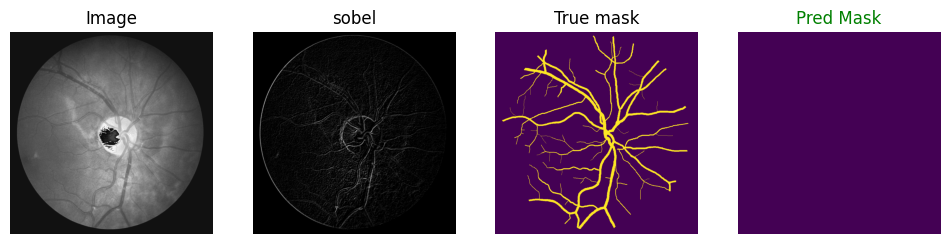

In [32]:
plot(nn.Sequential(UNETModel(3,1),nn.Sigmoid()),train_set[1],device)

# Train

**Define Loss**

In [33]:
class CustomSegLoss(nn.Module):
    def __init__(self,alpha=1):
        super().__init__()
        self.alpha=alpha
    def forward(self,pred,truth):
        
        pred=pred.squeeze()
        truth=truth.squeeze()
        # bce Loss
        # bce = nn.BCELoss()(pred,truth.type(torch.float32))

        # Abe Dice Loss

        erc = torch.pow(pred,2*(1-(pred**2)))
        abe_diceloss_all = 1-(torch.sum(2*erc*truth)/torch.sum(erc**2 +truth))
        return self.alpha*abe_diceloss_all

In [34]:
# unet_model =nn.Sequential(UNETModel(3,1),nn.Sigmoid()).to(device)

# unet_model = nn.DataParallel(unet_model,device_ids=[1,2,3,0]) 

In [35]:
model =nn.Sequential(UNETModel(3,1),nn.Sigmoid()).to(device)
model = nn.DataParallel(model,device_ids=[1,2,3,0]) 

In [36]:
# UNETModel

In [37]:
from torch.optim import Adam
optimizer =Adam(model.parameters(),lr=2e-4,weight_decay=1e-5)
criterion =CustomSegLoss()

In [38]:
from torchmetrics.classification import BinaryF1Score,AUROC, Recall, Specificity
def eval_for_seg(model,val_loader,device):
    with torch.no_grad():
        model.eval()
        truth_label=[]
        pred_label=[]
        for sample in val_loader:
            image,sobel,mask=sample.values()
            
            image=image.to(device)
            sobel=sobel.to(device)
            mask=mask.to(device)
            pred_mask = torch.where(model(image)>0.5,1,0).cpu().flatten()
            truth_label.extend(mask.flatten().tolist())
            pred_label.extend(pred_mask.detach().numpy().tolist())
        truth_label=torch.tensor(truth_label)
        pred_label= torch.tensor(pred_label)
        return BinaryF1Score()(pred_label,truth_label),\
            Recall(task='binary')(pred_label,truth_label).item(),\
            Specificity(task='binary')(pred_label,truth_label).item(),\
            AUROC(task='binary')(pred_label,truth_label).item()

In [39]:
from tqdm import tqdm
def train_one_epoch_for_seg(model,train_loader,optimizer,criterion,device):
    model.train()
    training_loss = 0 
    for sample in train_loader:
        image,sobel,mask=sample.values()
        image=image.to(device)
        sobel=sobel.to(device)
        mask=mask.to(device)

        pred_mask = model(image)

        loss = criterion(pred_mask,mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss+=loss.item()
    return training_loss/len(train_loader)


In [40]:
def train_seg(epochs,model,train_loader,val_loader,optimizer,criterion,device,save_dir='./best_seg_model.pth'):
    best_val_f1=0
    for e in tqdm(range(epochs)):
        training_loss=train_one_epoch_for_seg(model,train_loader,optimizer,criterion,device)
        val_f1, val_recall, val_specificity, val_auroc = eval_for_seg(model,val_loader,device)
        print(f'Epoch [{e}/{epochs}]: training loss {training_loss} val f1 {val_f1} val recall {val_recall} val specificity {val_specificity} val auroc {val_auroc}')
        if best_val_f1 < val_f1:
            best_val_f1=val_f1
            if isinstance(model,nn.DataParallel):
                torch.save(model.module.state_dict(), save_dir)
            else:
                torch.save(model.state_dict(), save_dir)
            print('===>Save model')
        if e%10==0:
            print(training_loss)
            plot(model,test_set[0],device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [0/20]: training loss 0.4530753314495087 val f1 0.0001324336335528642 val recall 6.674015457974747e-05 val specificity 0.9994730949401855 val auroc 0.499769926071167
===>Save model
0.4530753314495087


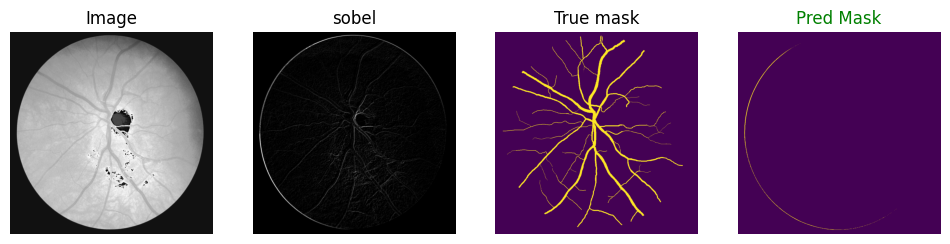

  5%|▌         | 1/20 [00:25<08:03, 25.46s/it]

Epoch [1/20]: training loss 0.3047027200460434 val f1 0.2827957272529602 val recall 0.17528977990150452 val specificity 0.9956698417663574 val auroc 0.5854797959327698


 10%|█         | 2/20 [00:52<07:53, 26.31s/it]

===>Save model
Epoch [2/20]: training loss 0.27308112382888794 val f1 0.6273778676986694 val recall 0.5745207667350769 val specificity 0.9827218055725098 val auroc 0.7786213159561157


 15%|█▌        | 3/20 [01:16<07:06, 25.10s/it]

===>Save model
Epoch [3/20]: training loss 0.22786371409893036 val f1 0.7260730862617493 val recall 0.7682114243507385 val specificity 0.9766111969947815 val auroc 0.87241131067276


 20%|██        | 4/20 [01:45<07:12, 27.01s/it]

===>Save model


 25%|██▌       | 5/20 [02:08<06:21, 25.41s/it]

Epoch [4/20]: training loss 0.20047037303447723 val f1 0.6866609454154968 val recall 0.7027221322059631 val specificity 0.9768668413162231 val auroc 0.8397944569587708
Epoch [5/20]: training loss 0.1930510699748993 val f1 0.7284730076789856 val recall 0.8298298120498657 val specificity 0.9698485136032104 val auroc 0.8998391628265381


 30%|███       | 6/20 [02:39<06:21, 27.24s/it]

===>Save model
Epoch [6/20]: training loss 0.17696506679058074 val f1 0.7417176365852356 val recall 0.717413604259491 val specificity 0.9854062795639038 val auroc 0.8514100313186646


 35%|███▌      | 7/20 [03:08<06:02, 27.89s/it]

===>Save model
Epoch [7/20]: training loss 0.16627423763275145 val f1 0.7700387239456177 val recall 0.7786229252815247 val specificity 0.9836164116859436 val auroc 0.8811196088790894


 40%|████      | 8/20 [03:33<05:21, 26.80s/it]

===>Save model


 45%|████▌     | 9/20 [03:58<04:50, 26.37s/it]

Epoch [8/20]: training loss 0.15794785916805268 val f1 0.7680805325508118 val recall 0.8103847503662109 val specificity 0.9798445701599121 val auroc 0.8951146602630615


 50%|█████     | 10/20 [04:20<04:09, 24.98s/it]

Epoch [9/20]: training loss 0.14965335726737977 val f1 0.7565933465957642 val recall 0.843177855014801 val specificity 0.9740669131278992 val auroc 0.9086223244667053
Epoch [10/20]: training loss 0.14448032677173614 val f1 0.7727183699607849 val recall 0.8560651540756226 val specificity 0.9758179783821106 val auroc 0.915941596031189
===>Save model
0.14448032677173614


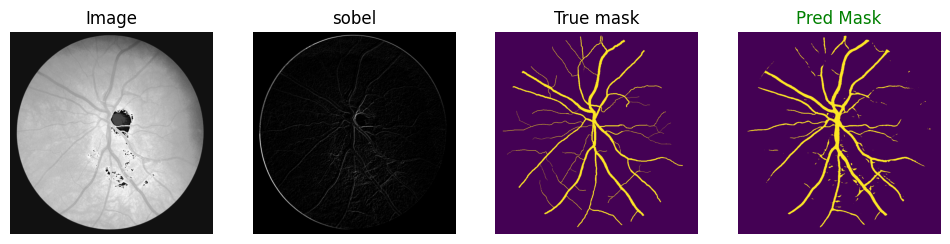

 55%|█████▌    | 11/20 [04:49<03:56, 26.27s/it]

Epoch [11/20]: training loss 0.13982179164886474 val f1 0.783470630645752 val recall 0.8494019508361816 val specificity 0.9785581231117249 val auroc 0.9139800667762756


 60%|██████    | 12/20 [05:13<03:25, 25.63s/it]

===>Save model


 65%|██████▌   | 13/20 [05:38<02:58, 25.43s/it]

Epoch [12/20]: training loss 0.1355226993560791 val f1 0.7801746129989624 val recall 0.8238705992698669 val specificity 0.9806262254714966 val auroc 0.9022484421730042
Epoch [13/20]: training loss 0.1319732666015625 val f1 0.7851266860961914 val recall 0.8047096729278564 val specificity 0.9835153818130493 val auroc 0.8941125273704529


 70%|███████   | 14/20 [06:07<02:39, 26.51s/it]

===>Save model


 75%|███████▌  | 15/20 [06:33<02:11, 26.28s/it]

Epoch [14/20]: training loss 0.1284189462661743 val f1 0.7813798189163208 val recall 0.8567777872085571 val specificity 0.9773946404457092 val auroc 0.9170862436294556


 80%|████████  | 16/20 [07:03<01:49, 27.50s/it]

Epoch [15/20]: training loss 0.1264403909444809 val f1 0.7666650414466858 val recall 0.8771765828132629 val specificity 0.972358226776123 val auroc 0.9247673749923706


 85%|████████▌ | 17/20 [07:27<01:18, 26.27s/it]

Epoch [16/20]: training loss 0.12414932548999787 val f1 0.7756813168525696 val recall 0.8452489376068115 val specificity 0.9775348901748657 val auroc 0.9113919138908386
Epoch [17/20]: training loss 0.11612902581691742 val f1 0.7921671271324158 val recall 0.8091748356819153 val specificity 0.9842825531959534 val auroc 0.8967286944389343


 90%|█████████ | 18/20 [07:52<00:52, 26.10s/it]

===>Save model


 95%|█████████▌| 19/20 [08:17<00:25, 25.56s/it]

Epoch [18/20]: training loss 0.11154334545135498 val f1 0.7915987968444824 val recall 0.8192977905273438 val specificity 0.9831449389457703 val auroc 0.9012213945388794
Epoch [19/20]: training loss 0.1085139274597168 val f1 0.7935574054718018 val recall 0.8178166151046753 val specificity 0.9836398363113403 val auroc 0.9007282257080078


100%|██████████| 20/20 [08:42<00:00, 26.14s/it]

===>Save model


In [41]:
train_seg(20,model,train_loader,test_loader,optimizer,criterion,device)

In [42]:
f

NameError: name 'f' is not defined

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [0/20]: training loss 0.5428491503000259 val f1 0.1623222529888153 val recall 0.690323531627655 val specificity 0.5417677760124207 val auroc 0.6160457134246826
===>Save model
0.5428491503000259


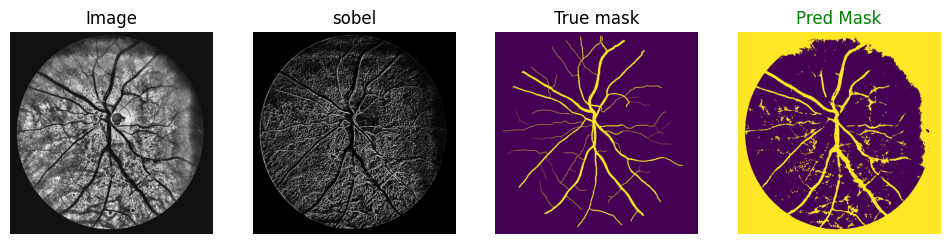

 10%|█         | 2/20 [00:42<06:18, 21.00s/it]

Epoch [1/20]: training loss 0.40741303861141204 val f1 0.1814253032207489 val recall 0.6659978032112122 val specificity 0.6183784008026123 val auroc 0.6421880722045898
===>Save model


 15%|█▌        | 3/20 [01:02<05:53, 20.80s/it]

Epoch [2/20]: training loss 0.34270858466625215 val f1 0.6416513323783875 val recall 0.7805562019348145 val specificity 0.9561348557472229 val auroc 0.8683454990386963
===>Save model


 20%|██        | 4/20 [01:23<05:31, 20.74s/it]

Epoch [3/20]: training loss 0.2977234721183777 val f1 0.6708193421363831 val recall 0.8397719860076904 val specificity 0.9553586840629578 val auroc 0.8975653052330017
===>Save model


 25%|██▌       | 5/20 [01:44<05:10, 20.70s/it]

Epoch [4/20]: training loss 0.26452750265598296 val f1 0.7338119745254517 val recall 0.8408936262130737 val specificity 0.9696794152259827 val auroc 0.9052864909172058
===>Save model


 30%|███       | 6/20 [02:04<04:49, 20.66s/it]

Epoch [5/20]: training loss 0.23219418227672578 val f1 0.7352916598320007 val recall 0.8154484033584595 val specificity 0.9729321599006653 val auroc 0.8941903114318848
===>Save model


 35%|███▌      | 7/20 [02:25<04:28, 20.65s/it]

Epoch [6/20]: training loss 0.2095930814743042 val f1 0.7692038416862488 val recall 0.8047893643379211 val specificity 0.9806537628173828 val auroc 0.8927215337753296
===>Save model


 40%|████      | 8/20 [02:45<04:07, 20.61s/it]

Epoch [7/20]: training loss 0.18933025896549224 val f1 0.7572695016860962 val recall 0.8440992832183838 val specificity 0.9740990400314331 val auroc 0.9090991616249084


 45%|████▌     | 9/20 [03:06<03:47, 20.66s/it]

Epoch [8/20]: training loss 0.17172376811504364 val f1 0.7616935968399048 val recall 0.8217090368270874 val specificity 0.9774170517921448 val auroc 0.8995630145072937


 50%|█████     | 10/20 [03:27<03:26, 20.62s/it]

Epoch [9/20]: training loss 0.15606182515621186 val f1 0.7650587558746338 val recall 0.835334837436676 val specificity 0.9765763282775879 val auroc 0.9059555530548096
Epoch [10/20]: training loss 0.14499728381633759 val f1 0.772807240486145 val recall 0.782833993434906 val specificity 0.9836539030075073 val auroc 0.883243978023529
===>Save model
0.14499728381633759


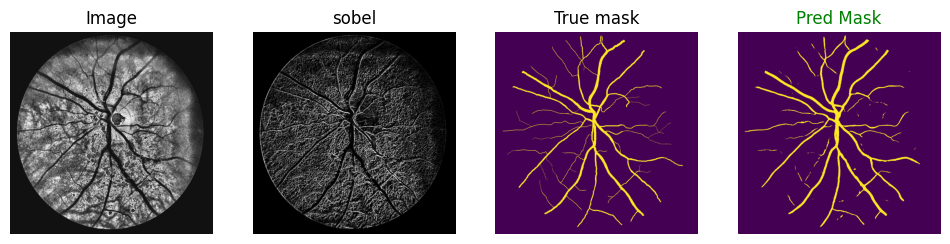

 60%|██████    | 12/20 [04:09<02:46, 20.77s/it]

Epoch [11/20]: training loss 0.1327919155359268 val f1 0.7688642144203186 val recall 0.7586675882339478 val specificity 0.9855570793151855 val auroc 0.8721123337745667


 65%|██████▌   | 13/20 [04:29<02:25, 20.72s/it]

Epoch [12/20]: training loss 0.12237668335437775 val f1 0.7609721422195435 val recall 0.7905844449996948 val specificity 0.9806869029998779 val auroc 0.8856356739997864


 70%|███████   | 14/20 [04:50<02:04, 20.68s/it]

Epoch [13/20]: training loss 0.11705319285392761 val f1 0.7724767923355103 val recall 0.7990884780883789 val specificity 0.9818589687347412 val auroc 0.8904737234115601


 75%|███████▌  | 15/20 [05:11<01:43, 20.71s/it]

Epoch [14/20]: training loss 0.10780282616615296 val f1 0.7762628793716431 val recall 0.7708982825279236 val specificity 0.9855254292488098 val auroc 0.8782119154930115
===>Save model


 80%|████████  | 16/20 [05:31<01:22, 20.69s/it]

Epoch [15/20]: training loss 0.10317334234714508 val f1 0.7722328305244446 val recall 0.780009388923645 val specificity 0.9838545322418213 val auroc 0.8819319605827332


 85%|████████▌ | 17/20 [05:52<01:02, 20.67s/it]

Epoch [16/20]: training loss 0.09788905680179597 val f1 0.772077202796936 val recall 0.7871742844581604 val specificity 0.9830609560012817 val auroc 0.8851175308227539


 90%|█████████ | 18/20 [06:13<00:41, 20.69s/it]

Epoch [17/20]: training loss 0.09049957990646362 val f1 0.7767751812934875 val recall 0.8001024723052979 val specificity 0.9825213551521301 val auroc 0.8913118839263916
===>Save model


 95%|█████████▌| 19/20 [06:33<00:20, 20.66s/it]

Epoch [18/20]: training loss 0.08263953626155854 val f1 0.7766354084014893 val recall 0.7789695262908936 val specificity 0.9847345948219299 val auroc 0.8818520307540894


100%|██████████| 20/20 [06:54<00:00, 20.71s/it]

Epoch [19/20]: training loss 0.08049868643283845 val f1 0.7723965644836426 val recall 0.7755851745605469 val specificity 0.9843561053276062 val auroc 0.8799706697463989


In [ ]:
train_seg(20,model,train_loader,test_loader,optimizer,criterion,device)

In [ ]:
f

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [0/20]: training loss 0.3897475600242615 val f1 0.655998706817627 val recall 0.7500215172767639 val specificity 0.9639188051223755 val auroc 0.8569701313972473
===>Save model
0.3897475600242615


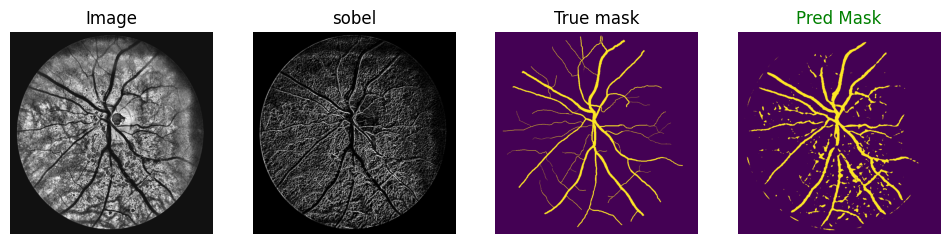

 10%|█         | 2/20 [00:45<06:44, 22.45s/it]

Epoch [1/20]: training loss 0.2844361037015915 val f1 0.6700357794761658 val recall 0.8039518594741821 val specificity 0.9599423408508301 val auroc 0.8819471597671509
===>Save model


 15%|█▌        | 3/20 [01:07<06:18, 22.27s/it]

Epoch [2/20]: training loss 0.2404491573572159 val f1 0.7262335419654846 val recall 0.794126033782959 val specificity 0.9735866189002991 val auroc 0.8838563561439514
===>Save model


 20%|██        | 4/20 [01:29<05:56, 22.28s/it]

Epoch [3/20]: training loss 0.21473832726478576 val f1 0.7307674288749695 val recall 0.847873330116272 val specificity 0.9682223200798035 val auroc 0.9080477952957153
===>Save model


 25%|██▌       | 5/20 [01:51<05:32, 22.20s/it]

Epoch [4/20]: training loss 0.1923081487417221 val f1 0.7434002161026001 val recall 0.8628898859024048 val specificity 0.9691669940948486 val auroc 0.9160284399986267
===>Save model


 30%|███       | 6/20 [02:13<05:10, 22.17s/it]

Epoch [5/20]: training loss 0.1825142651796341 val f1 0.7489227652549744 val recall 0.8324068784713745 val specificity 0.9737417697906494 val auroc 0.903074324131012
===>Save model


 35%|███▌      | 7/20 [02:35<04:47, 22.14s/it]

Epoch [6/20]: training loss 0.1717791885137558 val f1 0.7689530253410339 val recall 0.8446202874183655 val specificity 0.9763203859329224 val auroc 0.9104702472686768
===>Save model


 40%|████      | 8/20 [02:57<04:25, 22.14s/it]

Epoch [7/20]: training loss 0.16517688930034638 val f1 0.7712221145629883 val recall 0.8508551120758057 val specificity 0.9760870933532715 val auroc 0.9134711027145386
===>Save model


 45%|████▌     | 9/20 [03:19<04:02, 22.07s/it]

Epoch [8/20]: training loss 0.15877141952514648 val f1 0.763975203037262 val recall 0.86700838804245 val specificity 0.9729226231575012 val auroc 0.9199655652046204


 50%|█████     | 10/20 [03:41<03:40, 22.07s/it]

Epoch [9/20]: training loss 0.15019143223762513 val f1 0.7709956765174866 val recall 0.8618543148040771 val specificity 0.9748646020889282 val auroc 0.9183594584465027
Epoch [10/20]: training loss 0.14081030786037446 val f1 0.7715087532997131 val recall 0.8744725584983826 val specificity 0.9736136794090271 val auroc 0.9240431785583496
===>Save model
0.14081030786037446


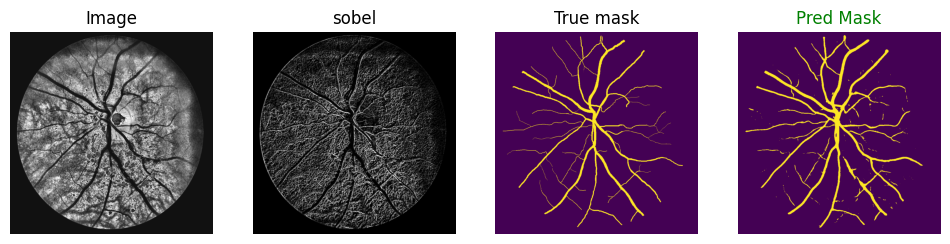

 60%|██████    | 12/20 [04:26<02:58, 22.30s/it]

Epoch [11/20]: training loss 0.1329642951488495 val f1 0.7718240022659302 val recall 0.8799818158149719 val specificity 0.9730864763259888 val auroc 0.926534116268158
===>Save model


 65%|██████▌   | 13/20 [04:49<02:35, 22.27s/it]

Epoch [12/20]: training loss 0.12691254913806915 val f1 0.7797756195068359 val recall 0.8529908061027527 val specificity 0.977489709854126 val auroc 0.9152402877807617
===>Save model


 70%|███████   | 14/20 [05:11<02:13, 22.23s/it]

Epoch [13/20]: training loss 0.11969754695892335 val f1 0.7803902626037598 val recall 0.8521813154220581 val specificity 0.9776906371116638 val auroc 0.9149359464645386
===>Save model


 75%|███████▌  | 15/20 [05:33<01:50, 22.18s/it]

Epoch [14/20]: training loss 0.11452973783016204 val f1 0.7812595367431641 val recall 0.8573935031890869 val specificity 0.9773073196411133 val auroc 0.9173504114151001
===>Save model


 80%|████████  | 16/20 [05:55<01:28, 22.12s/it]

Epoch [15/20]: training loss 0.11039944887161254 val f1 0.7769834995269775 val recall 0.8550167083740234 val specificity 0.976746678352356 val auroc 0.9158816933631897


 85%|████████▌ | 17/20 [06:17<01:06, 22.10s/it]

Epoch [16/20]: training loss 0.1053015410900116 val f1 0.7792577743530273 val recall 0.8557938933372498 val specificity 0.9770967364311218 val auroc 0.9164453744888306


 90%|█████████ | 18/20 [06:39<00:44, 22.16s/it]

Epoch [17/20]: training loss 0.09332537055015563 val f1 0.7777864933013916 val recall 0.8522416353225708 val specificity 0.9771926999092102 val auroc 0.9147171378135681


 95%|█████████▌| 19/20 [07:01<00:22, 22.18s/it]

Epoch [18/20]: training loss 0.08534338474273681 val f1 0.7852458357810974 val recall 0.8376879692077637 val specificity 0.9801061153411865 val auroc 0.9088970422744751
===>Save model


100%|██████████| 20/20 [07:23<00:00, 22.20s/it]

Epoch [19/20]: training loss 0.08071613311767578 val f1 0.7832334637641907 val recall 0.8372552394866943 val specificity 0.97978276014328 val auroc 0.9085190296173096


In [ ]:
# train_seg(20,model,train_loader,test_loader,optimizer,criterion,device)

**Eval**

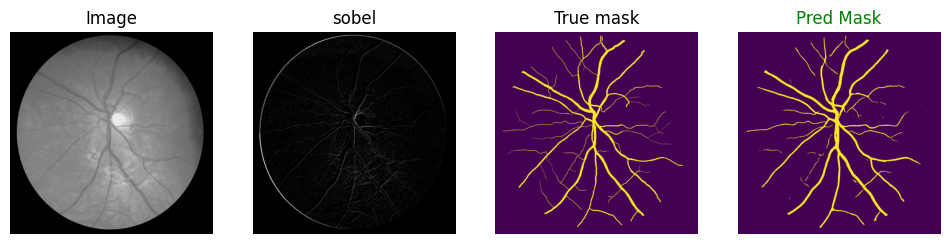

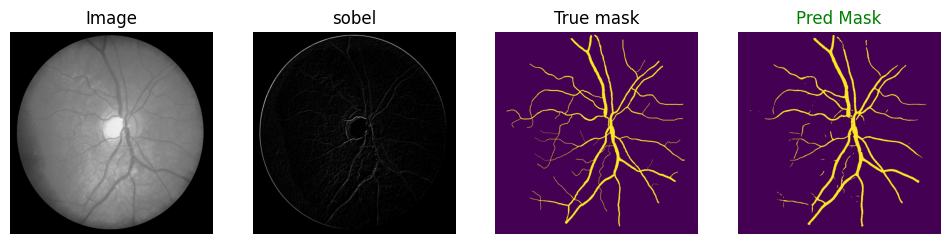

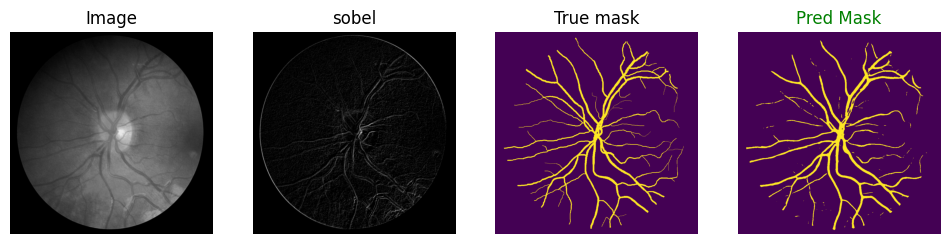

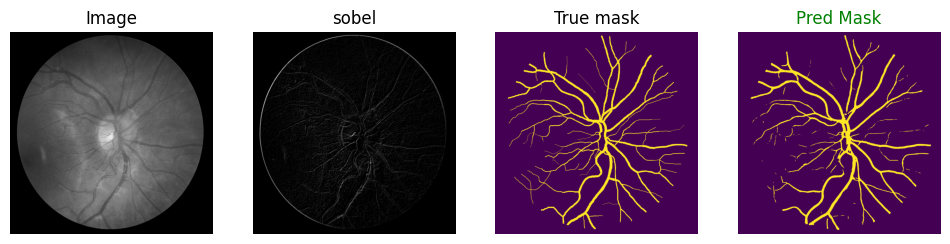

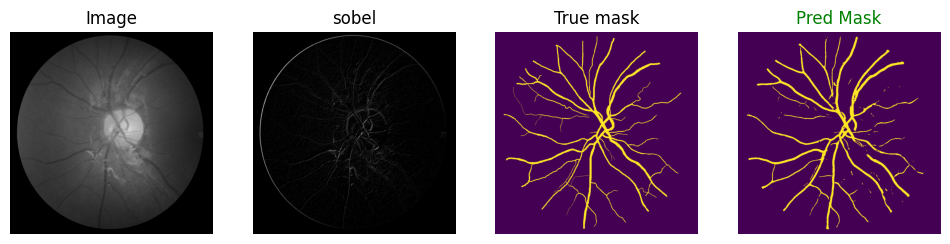

In [45]:
for i in range(5):
    plot(model,test_set[i],device)
    plt.show()

In [ ]:
eval_for_seg(model,test_loader,device)

(tensor(0.7832), 0.8372552394866943, 0.97978276014328, 0.9085190296173096)